# 1- Import Libraries & Setup Kernel

In [1]:
# Librerías de Dataset y procesamiento
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Librerías para plotear
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Configuración de Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Librerías ML 
from sklearn.cluster import KMeans

# 2- Import & Explore


In [2]:
# Crear un DataFrame llamado "data" para importar el CSV
data = pd.read_csv('../data/OnlineRetail-02.csv')

# Convertir InvoiceDate a formato fecha
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [3]:
data.head()

,CustomerID,Country,InvoiceNo,InvoiceDate,Description,Quantity,UnitPrice,TotalPrice,FirstInvoice,InvoiceYear,InvoiceMonth,InvoiceWeekYear,InvoiceDayYear,InvoiceDayWeek,InvoiceHour,InvoiceTimestamp
0,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white hanging heart t-light holder,6,2.55,15.30,1,2010,12,48,335,2,8,1291188360
1,17850.0,United Kingdom,536365,2010-12-01 08:26:00,white metal lantern,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
2,17850.0,United Kingdom,536365,2010-12-01 08:26:00,cream cupid hearts coat hanger,8,2.75,22.00,1,2010,12,48,335,2,8,1291188360
3,17850.0,United Kingdom,536365,2010-12-01 08:26:00,knitted union flag hot water bottle,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360
4,17850.0,United Kingdom,536365,2010-12-01 08:26:00,red woolly hottie white heart.,6,3.39,20.34,1,2010,12,48,335,2,8,1291188360


# 4- RFM Clulsters

In [168]:
# Get First Purchase (TimeStamp)
model_df = data.groupby(['CustomerID']).agg({'InvoiceDate': min, 'InvoiceTimestamp': min}).reset_index()
model_df.columns = ['CustomerID','FirstPurchaseDate', 'InvoiceTimestamp']

model_df.head()

,CustomerID,FirstPurchaseDate,InvoiceTimestamp
0,12346.0,2011-01-18 10:01:00,1295341260
1,12347.0,2010-12-07 14:57:00,1291730220
2,12348.0,2010-12-16 19:09:00,1292522940
3,12349.0,2011-11-21 09:51:00,1321865460
4,12350.0,2011-02-02 16:01:00,1296658860


In [5]:
# Get All invoices for each CustomerID
model_invoices = data.groupby(['CustomerID','InvoiceNo', 'InvoiceDate']).TotalPrice.agg(['sum']).reset_index()
model_invoices.columns = ['CustomerID','InvoiceNo', 'InvoiceDate', 'Revenue']

model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue
0,12346.0,541431,2011-01-18 10:01:00,77183.60
1,12347.0,537626,2010-12-07 14:57:00,711.79
2,12347.0,542237,2011-01-26 14:30:00,475.39
3,12347.0,549222,2011-04-07 10:43:00,636.25
4,12347.0,556201,2011-06-09 13:01:00,382.52


In [6]:
# Count days between each invoice
list_invoices = model_invoices.InvoiceNo
model_invoices['days_firstInvoice'] = 0

for invoice in list_invoices:
    date_invoices = model_invoices.InvoiceDate[model_invoices.InvoiceNo == invoice]
    get_user = float(model_invoices.CustomerID[model_invoices.InvoiceNo == invoice].unique())
    first_purchase = model_invoices.InvoiceDate[model_invoices.CustomerID == get_user].min()
    days = (date_invoices - first_purchase).dt.days
    model_invoices.days_firstInvoice[model_invoices.InvoiceNo == invoice] = days


C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Chorch\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


---
# Recency (Final)

Function to get the "Recency value" of  customers by each months, and also invert results to determine that high value as the most valuable

**Formula**: (Fisrt_Invoices_Date + 30 days - Last_Inovice_Date)<br>

In [7]:
def recency_1M(customer):
    day = 30
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)

def recency_2M(customer):
    day = 60
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)    
#     return -((finaldate - (last_invoices + timedelta(days=30))).days)

def recency_3M(customer):
    day = 90
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=60))).days)


def recency_4M(customer):
    day = 120
    finaldate = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].min() + timedelta(days=day) 
    last_invoices = model_invoices.InvoiceDate[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)].max()
    return -((finaldate - last_invoices).days)
#     return -((finaldate - (last_invoices + timedelta(days=90))).days)

model_invoices['Recency_1M'] = model_invoices.CustomerID.apply(recency_1M)
model_invoices['Recency_2M'] = model_invoices.CustomerID.apply(recency_2M)
model_invoices['Recency_3M'] = model_invoices.CustomerID.apply(recency_3M)
model_invoices['Recency_4M'] = model_invoices.CustomerID.apply(recency_4M)

---
# Frequency (Final)

Function to get the "Frequency value" of  customers by each months, and also invert results to determine that high value as the most valuable.

**Formula**: -(Days / Amonut of Invoices)

In [8]:
def frequency_1M(customer):
    day = 30
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    if n_invoices == 0:
        return -(round(day / 1))
    else:
        return -(round(day / n_invoices))

def frequency_2M(customer):
    day = 60
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    if n_invoices == 0:
        return -(round((day - 30) / 1))
    else:
        return -(round((day - 30) / n_invoices))
    
def frequency_3M(customer):
    day = 90
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    if n_invoices == 0:
        return -(round((day - 60) / 1))
    else:
        return -(round((day - 60) / n_invoices))
    
def frequency_4M(customer):
    day = 120
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 90)])
    if n_invoices == 0:
        return -(round((day - 90) / 1))
    else:
        return -(round((day - 90) / n_invoices))
    
model_invoices['Frequency_1M'] = model_invoices.CustomerID.apply(frequency_1M)
model_invoices['Frequency_2M'] = model_invoices.CustomerID.apply(frequency_2M)
model_invoices['Frequency_3M'] = model_invoices.CustomerID.apply(frequency_3M)
model_invoices['Frequency_4M'] = model_invoices.CustomerID.apply(frequency_4M)

---
# Monetary (Final)

Function to get the sum of "Monetary value" of customers by each months.

**Result**: Revenue by each month

In [9]:
def monetary_1M(customer):
    day = 30
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_2M(customer):
    day = 60
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 30)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_3M(customer):
    day = 90
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day) & (model_invoices.days_firstInvoice >= 60)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

def monetary_rev(customer):
    day = 180
    revenue = sum(model_invoices.Revenue[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    n_invoices = len(model_invoices[(model_invoices.CustomerID == customer) & (model_invoices.days_firstInvoice <= day)])
    return round(revenue)

model_invoices['Monetary_1M'] = model_invoices.CustomerID.apply(monetary_1M)
model_invoices['Monetary_2M'] = model_invoices.CustomerID.apply(monetary_2M)
model_invoices['Monetary_3M'] = model_invoices.CustomerID.apply(monetary_3M)
model_invoices['Revenue'] = model_invoices.CustomerID.apply(monetary_rev)


In [10]:
model_invoices.head()

,CustomerID,InvoiceNo,InvoiceDate,Revenue,days_firstInvoice,Recency_1M,Recency_2M,Recency_3M,Recency_4M,Frequency_1M,Frequency_2M,Frequency_3M,Frequency_4M,Monetary_1M,Monetary_2M,Monetary_3M
0,12346.0,541431,2011-01-18 10:01:00,77184,0,-30,-60,-90,-120,-30,-30,-30,-30,77184,0,0
1,12347.0,537626,2010-12-07 14:57:00,1823,0,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
2,12347.0,542237,2011-01-26 14:30:00,1823,49,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
3,12347.0,549222,2011-04-07 10:43:00,1823,120,-30,-10,-40,1,-30,-30,-30,-30,712,475,0
4,12347.0,556201,2011-06-09 13:01:00,1823,183,-30,-10,-40,1,-30,-30,-30,-30,712,475,0


In [146]:
# Make the Dataset with RFM from Invoices to each customer
rfm_model = pd.pivot_table(
    model_invoices, index='CustomerID', values=['Recency_1M', 'Recency_2M', 'Recency_3M', 'Frequency_1M', 
                                                'Frequency_2M', 'Frequency_3M', 'Monetary_1M', 'Monetary_2M', 
                                                'Monetary_3M','Revenue']).reset_index()

rfm_model.head()

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue
0,12346.0,-30,-30,-30,77184,0,0,-30,-60,-90,77184
1,12347.0,-30,-30,-30,712,475,0,-30,-10,-40,1823
2,12348.0,-30,-30,-30,893,227,0,-30,-20,-50,1487
3,12349.0,-30,-30,-30,1758,0,0,-30,-60,-90,1758
4,12350.0,-30,-30,-30,334,0,0,-30,-60,-90,334


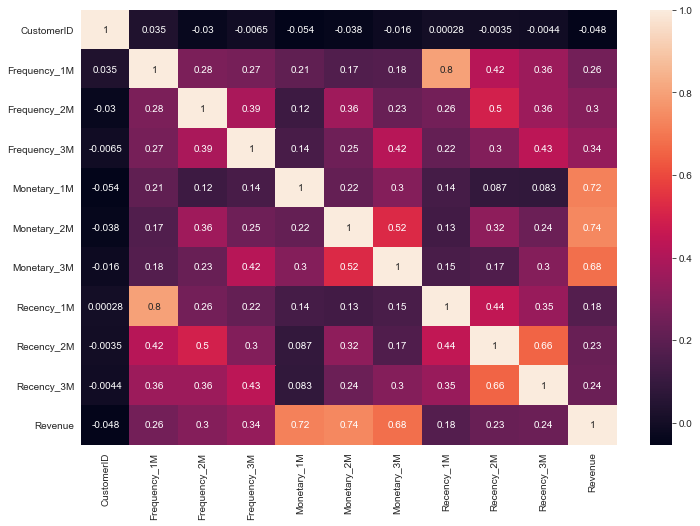

In [147]:
plt.figure(figsize=(12, 8))
sns.heatmap(rfm_model.corr(), annot=True)
plt.show()

---
# Dummies productos

In [148]:
# Dummies de productos
dummy_product = pd.pivot_table(data, index='CustomerID', values=['Quantity'], columns='Description').reset_index()

In [149]:
products = dummy_product.Quantity
ids = dummy_product.CustomerID

dummy_product = pd.merge(ids, products, left_index=True, right_index=True)
dummy_product = dummy_product.fillna(0)

dummy_product.shape

(4339, 3878)

In [150]:
total = dummy_product.isin([0]).sum().reset_index()
total.columns = ['Products', 'Amount']
total = total.sort_values(by='Amount')

dummy_colunms = list(total.Products[:300])
dummy_product = dummy_product[dummy_colunms]
dummy_product.shape

(4339, 300)

In [151]:
dummy_product.head()

,CustomerID,regency cakestand 3 tier,white hanging heart t-light holder,party bunting,assorted colour bird ornament,set of 3 cake tins pantry design,jumbo bag red retrospot,pack of 72 retrospot cake cases,paper chain kit 50's christmas,natural slate heart chalkboard,baking set 9 piece retrospot,heart of wicker small,jam making set with jars,spotty bunting,jam making set printed,lunch bag red retrospot,lunch bag spaceboy design,retrospot tea set ceramic 11 pc,heart of wicker large,rex cash+carry jumbo shopper,lunch bag cars blue,hot water bottle keep calm,set of 3 regency cake tins,recipe box pantry yellow design,paper chain kit vintage christmas,lunch bag black skull.,rabbit night light,vintage snap cards,lunch bag pink polkadot,set of 4 pantry jelly moulds,homemade jam scented candles,set/20 red retrospot paper napkins,scottie dog hot water bottle,roses regency teacup and saucer,60 teatime fairy cake cases,6 ribbons rustic charm,wooden picture frame white finish,pack of 60 pink paisley cake cases,gardeners kneeling pad keep calm,victorian glass hanging t-light,lunch bag apple design,lunch bag suki design,jumbo bag alphabet,set of 6 spice tins pantry design,wooden frame antique white,jumbo bag 50's christmas,alarm clock bakelike red,gingerbread man cookie cutter,green regency teacup and saucer,red hanging heart t-light holder,chocolate hot water bottle,doormat keep calm and come in,small white heart of wicker,lunch bag alphabet design,jumbo bag vintage leaf,set of 3 heart cookie cutters,ivory kitchen scales,hand warmer owl design,jumbo shopper vintage red paisley,lunch bag woodland,jumbo bag pink polkadot,retrospot heart hot water bottle,set of 20 vintage christmas napkins,set of 60 pantry design cake cases,traditional knitting nancy,jumbo bag vintage doily,clothes pegs retrospot pack 24,please one person metal sign,home building block word,pack of 20 napkins pantry design,set/5 red retrospot lid glass bowls,gardeners kneeling pad cup of tea,plasters in tin woodland animals,large white heart of wicker,red harmonica in box,antique silver t-light glass,jumbo bag apples,wooden heart christmas scandinavian,vintage heads and tails card game,60 cake cases vintage christmas,plasters in tin spaceboy,love building block word,grey heart hot water bottle,feltcraft 6 flower friends,wooden box of dominoes,red retrospot charlotte bag,jumbo storage bag suki,hand warmer bird design,wooden star christmas scandinavian,postage,gin + tonic diet metal sign,hand warmer scotty dog design,doormat red retrospot,set of 3 butterfly cookie cutters,72 sweetheart fairy cake cases,hot water bottle tea and sympathy,paper bunting retrospot,set of 12 fairy cake baking cases,alarm clock bakelike green,spaceboy lunch box,lunch bag vintage doily,christmas craft little friends,pink regency teacup and saucer,colour glass t-light holder hanging,hot water bottle i am so poorly,love hot water bottle,plasters in tin vintage paisley,jumbo bag strawberry,doormat new england,doormat union flag,pink cream felt craft trinket box,zinc metal heart decoration,enamel flower jug cream,lunch bag dolly girl design,jumbo bag pink vintage paisley,world war 2 gliders asstd designs,blue harmonica in box,jumbo bag baroque black white,plasters in tin circus parade,lunch bag vintage leaf design,hanging heart jar t-light holder,box of 6 mini 50's crackers,hand warmer union jack,jumbo bag doiley patterns,childrens apron spaceboy design,strawberry ceramic trinket box,baking set spaceboy design,pack of 72 skull cake cases,popcorn holder,plasters in tin strongman,paper chain kit retrospot,red kitchen scales,alarm clock bakelike pink,set of 20 kids cookie cutters,lunch bag doiley pattern,cream sweetheart mini chest,wooden school colouring set,3 stripey mice feltcraft,cook with wine metal sign,dolly girl lunch box,feltcraft butterfly hearts,pack of 60 dinosaur cake cases,jumbo bag vintage christmas,doormat hearts,wood black board ant white finish,playing cards keep calm & carry on,vintage doily

---
# Final Dataset

In [152]:
# WHIT DUMMIES
df_model_f = pd.merge(rfm_model, dummy_product, on='CustomerID')
df_model_f = pd.merge(df_model_f, model_df[['CustomerID', 'InvoiceTimestamp']], on='CustomerID')

df_model_f.head()


# WHIT -out DUMMIES
# df_model_f = pd.merge(rfm_model, customer_rev, on='CustomerID')

# df_model_predictor
# dummy_prod
# customer_rev

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue,regency cakestand 3 tier,white hanging heart t-light holder,party bunting,assorted colour bird ornament,set of 3 cake tins pantry design,jumbo bag red retrospot,pack of 72 retrospot cake cases,paper chain kit 50's christmas,natural slate heart chalkboard,baking set 9 piece retrospot,heart of wicker small,jam making set with jars,spotty bunting,jam making set printed,lunch bag red retrospot,lunch bag spaceboy design,retrospot tea set ceramic 11 pc,heart of wicker large,rex cash+carry jumbo shopper,lunch bag cars blue,hot water bottle keep calm,set of 3 regency cake tins,recipe box pantry yellow design,paper chain kit vintage christmas,lunch bag black skull.,rabbit night light,vintage snap cards,lunch bag pink polkadot,set of 4 pantry jelly moulds,homemade jam scented candles,set/20 red retrospot paper napkins,scottie dog hot water bottle,roses regency teacup and saucer,60 teatime fairy cake cases,6 ribbons rustic charm,wooden picture frame white finish,pack of 60 pink paisley cake cases,gardeners kneeling pad keep calm,victorian glass hanging t-light,lunch bag apple design,lunch bag suki design,jumbo bag alphabet,set of 6 spice tins pantry design,wooden frame antique white,jumbo bag 50's christmas,alarm clock bakelike red,gingerbread man cookie cutter,green regency teacup and saucer,red hanging heart t-light holder,chocolate hot water bottle,doormat keep calm and come in,small white heart of wicker,lunch bag alphabet design,jumbo bag vintage leaf,set of 3 heart cookie cutters,ivory kitchen scales,hand warmer owl design,jumbo shopper vintage red paisley,lunch bag woodland,jumbo bag pink polkadot,retrospot heart hot water bottle,set of 20 vintage christmas napkins,set of 60 pantry design cake cases,traditional knitting nancy,jumbo bag vintage doily,clothes pegs retrospot pack 24,please one person metal sign,home building block word,pack of 20 napkins pantry design,set/5 red retrospot lid glass bowls,gardeners kneeling pad cup of tea,plasters in tin woodland animals,large white heart of wicker,red harmonica in box,antique silver t-light glass,jumbo bag apples,wooden heart christmas scandinavian,vintage heads and tails card game,60 cake cases vintage christmas,plasters in tin spaceboy,love building block word,grey heart hot water bottle,feltcraft 6 flower friends,wooden box of dominoes,red retrospot charlotte bag,jumbo storage bag suki,hand warmer bird design,wooden star christmas scandinavian,postage,gin + tonic diet metal sign,hand warmer scotty dog design,doormat red retrospot,set of 3 butterfly cookie cutters,72 sweetheart fairy cake cases,hot water bottle tea and sympathy,paper bunting retrospot,set of 12 fairy cake baking cases,alarm clock bakelike green,spaceboy lunch box,lunch bag vintage doily,christmas craft little friends,pink regency teacup and saucer,colour glass t-light holder hanging,hot water bottle i am so poorly,love hot water bottle,plasters in tin vintage paisley,jumbo bag strawberry,doormat new england,doormat union flag,pink cream felt craft trinket box,zinc metal heart decoration,enamel flower jug cream,lunch bag dolly girl design,jumbo bag pink vintage paisley,world war 2 gliders asstd designs,blue harmonica in box,jumbo bag baroque black white,plasters in tin circus parade,lunch bag vintage leaf design,hanging heart jar t-light holder,box of 6 mini 50's crackers,hand warmer union jack,jumbo bag doiley patterns,childrens apron spaceboy design,strawberry ceramic trinket box,baking set spaceboy design,pack of 72 skull cake cases,popcorn holder,plasters in tin strongman,paper chain kit retrospot,red kitchen scales,alarm clock bakelike pink,set of 20 kids cookie cutters,lunch bag doiley pattern,cream sweetheart mini chest,wooden school colouring set,3 stripey mice feltcraft,cook with wine metal sign,dolly girl lunch box,feltcraft butterfly hearts,pack of 60 dinosaur cake cases,jumbo bag

In [153]:
def Q_bins_more(x):
    '''
    Function to create bins by Quartiles
    Function can be used, when the interval most higher 
    correspond with the value more higher.
    '''
    quartile = x.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
    return pd.cut(np.array(x), quartile, labels=[1, 2, 3, 4, 5, 6])

In [154]:
df_model_f['MonetaryBins'] = Q_bins_more(df_model_f.Revenue)
df_model_f['MonetaryBins'] = df_model_f['MonetaryBins'].fillna(value=1)


In [155]:
df_model_f.shape

(4339, 312)

In [156]:
# Create correlation matrix
corr_matrix = df_model_f.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(len(to_drop),'\n', to_drop)

3 
 ['open closed metal sign', 'feltcraft doll molly', 'regency milk jug pink ']


In [157]:
# Drop features 
df_model_f = df_model_f.drop(df_model_f[to_drop], axis=1)
df_model_f.shape

(4339, 309)

In [159]:
# Crear Dataset con Train-Test y Predicted

# Convertir InvoiceDate a formato fecha
# data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

cut_pred = '2011-09-01'
fin_pred = '2011-09-30'

pred_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_pred)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_pred))]

cut_test = '2011-06-01'
fin_test = '2011-08-31'

test_customers = model_df.CustomerID[(model_df.FirstPurchaseDate >= pd.to_datetime(cut_test)) & (model_df.FirstPurchaseDate <= pd.to_datetime(fin_test))]

cut_train = '2011-05-31'

train_customers = model_df.CustomerID[(model_df.FirstPurchaseDate <= pd.to_datetime(cut_train))]

print('Train:', len(train_customers), '\nTest:', len(test_customers), '\nPredict:', len(pred_customers))


Train: 2708 
Test: 594 
Predict: 287


In [160]:
# Define Train Test
df_train = df_model_f[df_model_f.CustomerID.isin(train_customers)]
df_test = df_model_f[df_model_f.CustomerID.isin(test_customers)]
df_predict = df_model_f[df_model_f.CustomerID.isin(pred_customers)]


# DATA
X_train = df_train.drop(columns=['Revenue'])
# Target
y_train = df_train['Revenue']

# DATA
X_test = df_test.drop(columns=['Revenue'])
# Target
y_test = df_test['Revenue']


In [161]:
df_model_f.head()

,CustomerID,Frequency_1M,Frequency_2M,Frequency_3M,Monetary_1M,Monetary_2M,Monetary_3M,Recency_1M,Recency_2M,Recency_3M,Revenue,regency cakestand 3 tier,white hanging heart t-light holder,party bunting,assorted colour bird ornament,set of 3 cake tins pantry design,jumbo bag red retrospot,pack of 72 retrospot cake cases,paper chain kit 50's christmas,natural slate heart chalkboard,baking set 9 piece retrospot,heart of wicker small,jam making set with jars,spotty bunting,jam making set printed,lunch bag red retrospot,lunch bag spaceboy design,retrospot tea set ceramic 11 pc,heart of wicker large,rex cash+carry jumbo shopper,lunch bag cars blue,hot water bottle keep calm,set of 3 regency cake tins,recipe box pantry yellow design,paper chain kit vintage christmas,lunch bag black skull.,rabbit night light,vintage snap cards,lunch bag pink polkadot,set of 4 pantry jelly moulds,homemade jam scented candles,set/20 red retrospot paper napkins,scottie dog hot water bottle,roses regency teacup and saucer,60 teatime fairy cake cases,6 ribbons rustic charm,wooden picture frame white finish,pack of 60 pink paisley cake cases,gardeners kneeling pad keep calm,victorian glass hanging t-light,lunch bag apple design,lunch bag suki design,jumbo bag alphabet,set of 6 spice tins pantry design,wooden frame antique white,jumbo bag 50's christmas,alarm clock bakelike red,gingerbread man cookie cutter,green regency teacup and saucer,red hanging heart t-light holder,chocolate hot water bottle,doormat keep calm and come in,small white heart of wicker,lunch bag alphabet design,jumbo bag vintage leaf,set of 3 heart cookie cutters,ivory kitchen scales,hand warmer owl design,jumbo shopper vintage red paisley,lunch bag woodland,jumbo bag pink polkadot,retrospot heart hot water bottle,set of 20 vintage christmas napkins,set of 60 pantry design cake cases,traditional knitting nancy,jumbo bag vintage doily,clothes pegs retrospot pack 24,please one person metal sign,home building block word,pack of 20 napkins pantry design,set/5 red retrospot lid glass bowls,gardeners kneeling pad cup of tea,plasters in tin woodland animals,large white heart of wicker,red harmonica in box,antique silver t-light glass,jumbo bag apples,wooden heart christmas scandinavian,vintage heads and tails card game,60 cake cases vintage christmas,plasters in tin spaceboy,love building block word,grey heart hot water bottle,feltcraft 6 flower friends,wooden box of dominoes,red retrospot charlotte bag,jumbo storage bag suki,hand warmer bird design,wooden star christmas scandinavian,postage,gin + tonic diet metal sign,hand warmer scotty dog design,doormat red retrospot,set of 3 butterfly cookie cutters,72 sweetheart fairy cake cases,hot water bottle tea and sympathy,paper bunting retrospot,set of 12 fairy cake baking cases,alarm clock bakelike green,spaceboy lunch box,lunch bag vintage doily,christmas craft little friends,pink regency teacup and saucer,colour glass t-light holder hanging,hot water bottle i am so poorly,love hot water bottle,plasters in tin vintage paisley,jumbo bag strawberry,doormat new england,doormat union flag,pink cream felt craft trinket box,zinc metal heart decoration,enamel flower jug cream,lunch bag dolly girl design,jumbo bag pink vintage paisley,world war 2 gliders asstd designs,blue harmonica in box,jumbo bag baroque black white,plasters in tin circus parade,lunch bag vintage leaf design,hanging heart jar t-light holder,box of 6 mini 50's crackers,hand warmer union jack,jumbo bag doiley patterns,childrens apron spaceboy design,strawberry ceramic trinket box,baking set spaceboy design,pack of 72 skull cake cases,popcorn holder,plasters in tin strongman,paper chain kit retrospot,red kitchen scales,alarm clock bakelike pink,set of 20 kids cookie cutters,lunch bag doiley pattern,cream sweetheart mini chest,wooden school colouring set,3 stripey mice feltcraft,cook with wine metal sign,dolly girl lunch box,feltcraft butterfly hearts,pack of 60 dinosaur cake cases,jumbo bag

# Make Model by Week (LinearRegression)

In [162]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [163]:
ltv_model = LinearRegression()

In [164]:
ltv_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [165]:
score_training = ltv_model.score(X_train, y_train)
print("Training set score: {:.5f}".format(score_training)) 

score_test = ltv_model.score(X_test, y_test)
print("Test set R^2: {:.5f}".format(score_test))

Training set score: 0.98944
Test set R^2: 0.94250


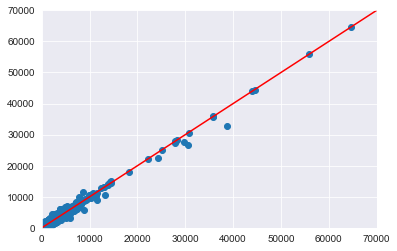

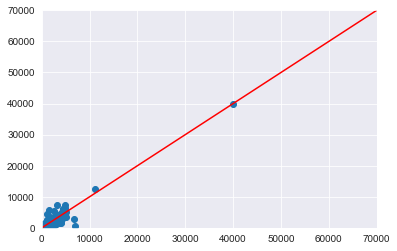

In [177]:
y_pred = ltv_model.predict(X_train)
plt.scatter(y_train, y_pred)
plt.plot([0, 70000], [0, 70000], color='red')
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.savefig('LR-Train.png')

plt.show()

y_pred = ltv_model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot([0, 70000], [0, 70000], color='red')
plt.xlim(0, 70000)
plt.ylim(0, 70000)
plt.savefig('LR-Test.png')

plt.show()

